In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data load and cleaning

In [89]:
df = pd.read_csv('drug.csv', skiprows= 6)
df.drop("[run number]", axis = 1, inplace = True)
df.drop("[step]", axis = 1, inplace = True)
df.drop("surplus", axis = 1, inplace = True)
X = df.loc[:,['tolerance_limit', 'no_of_dealers', 'no_of_consumers', 'consumer_network', 'franchise_limit', 'leave_consumer',
              'suspicion', 'allow_direct_connection', 'new_consumer']]
y = df.loc[:,['mean [brokered_for_someone] of consumers']]

# Split into training and test tests

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Initial Model Exploration 

In [91]:
from sklearn import tree
from sklearn.metrics import mean_squared_error

reg_treeTune = tree.DecisionTreeRegressor(random_state=42)
reg_treeTune.fit(X_train, y_train)
predictions = reg_treeTune.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

5.024368936463957

In [92]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(reg_treeTune, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [ 6.33878455  5.85348351  5.98827579  6.29961787  5.57253059  5.55375745
  5.57397248  5.65123315  5.66552816  5.43909551]
Mean: 5.79362790474
Standard deviation: 0.301950574424


# Plot validation curves to find optimal parameters to avoid overfitting

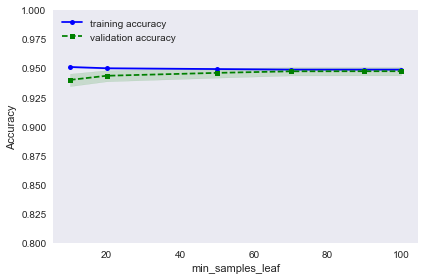

In [93]:
from sklearn.learning_curve import validation_curve
param_range = [10, 20, 50, 70, 90, 100]
train_scores, test_scores = validation_curve(
                reg_treeTune, 
                X=X_train, 
                y=y_train, 
                param_name='min_samples_leaf', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
#plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

# Create new model with the optimal parameters

In [94]:
reg_tree = tree.DecisionTreeRegressor(random_state=42, min_samples_leaf = 50, max_depth = 3)
reg_tree = reg_tree.fit(X_train, y_train)
predictions = reg_tree.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

6.0529131745738018

In [95]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(reg_tree, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)
feature_names=X_train.columns
feature_names

Scores: [ 5.9992711   6.16793451  5.98052869  6.60659879  5.86896731  5.97375938
  5.90455163  5.92883018  6.21262073  5.69803768]
Mean: 6.03410999926
Standard deviation: 0.235229955116


Index(['tolerance_limit', 'no_of_dealers', 'no_of_consumers',
       'consumer_network', 'franchise_limit', 'leave_consumer', 'suspicion',
       'allow_direct_connection', 'new_consumer'],
      dtype='object')

# Important attributes in the model.

In [96]:
feature_importances = reg_tree.feature_importances_
attributes = list(X_train)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.96443120498344725, 'no_of_consumers'),
 (0.015026942454654593, 'no_of_dealers'),
 (0.011117419235123214, 'suspicion'),
 (0.0094244333267750335, 'franchise_limit'),
 (0.0, 'tolerance_limit'),
 (0.0, 'new_consumer'),
 (0.0, 'leave_consumer'),
 (0.0, 'consumer_network'),
 (0.0, 'allow_direct_connection')]

# Test accuracy

In [97]:
final_predictions = reg_tree.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

6.0685985841836043

In [98]:
reg_tree.score(X_test, y_test)

0.92749600632532703

# Export Tree

In [99]:
dotfile = open("/Users/Hammad/Desktop/tree.dot", 'w')
tree.export_graphviz(reg_tree, out_file = dotfile, rounded=True, filled=True, feature_names=list(X_train))
dotfile.close()